# Poisson matrix factorization

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator

In [2]:
cmap = 'PuBuGn'

def fl(x,dp = 2):
    return round(x,dp)

In [3]:
def extract_overlapping_membership(i, cm, U, threshold=0.1):
    groups = np.where(U[i] > threshold)[0]
    wedge_sizes = U[i][groups]
    wedge_colors = [cm(c) for c in groups]
    return wedge_sizes, wedge_colors

def normalize_nonzero_membership(U):
    den1 = U.sum(axis=1, keepdims=True)
    nzz = den1 == 0.
    den1[nzz] = 1.
    return U / den1

def plot_L(values, indices = None, k_i = 5, figsize=(7, 7), int_ticks=False, xlab='Iterations'):

    fig, ax = plt.subplots(1,1, figsize=figsize)

    if indices is None:
        ax.plot(values[k_i:])
    else:
        ax.plot(indices[k_i:], values[k_i:])
    ax.set_xlabel(xlab)
    ax.set_ylabel('Log-likelihood values')
    if int_ticks:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid()

    plt.tight_layout()
    plt.show()

### Generate synthetic data

In [4]:
N = 100
K = 3


In [5]:
prng = np.random.RandomState(10)

#### Membership

In [6]:
alpha = 0.1
beta = 0.5
corr = 0.9 # correlation btw u and v
# u = prng.gamma(alpha, 1. / beta, size=(N, K))
u = prng.dirichlet(alpha * np.ones(K), N)
v = corr * u.copy() + (1. - corr) * prng.gamma(alpha, 1. / beta, size=(N, K))

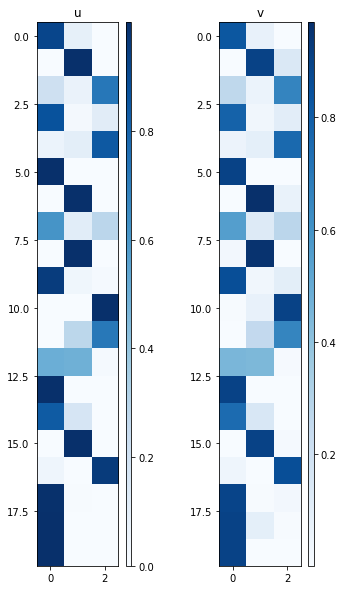

In [7]:
plt.figure(figsize=(6,10))
plt.subplot(1,2,1)
plt.imshow(u[:20], cmap='Blues', interpolation='nearest')
plt.title('u')
plt.colorbar(aspect = 100)
plt.subplot(1,2,2)
plt.imshow(v[:20], cmap='Blues', interpolation='nearest')
plt.title('v')
plt.colorbar(aspect = 100)

#### Affinity matrix

In [8]:
a = 0.1
avg_degree = 20.

p1 = avg_degree * K / N

C = p1 * a * np.ones((K,K))  # secondary-probabilities
np.fill_diagonal(C, p1 * np.ones(K))  # primary-probabilities

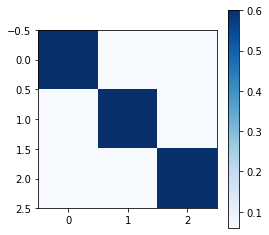

In [9]:
plt.figure(figsize=(4,4))
plt.imshow(C, cmap = 'Blues')
plt.colorbar()

In [10]:
lambda_pois = np.einsum('ik,kq->iq',u,C)
lambda_pois = np.einsum('iq,jq->ij',lambda_pois,v) 
np.fill_diagonal(lambda_pois, 0)

### Sample adjacency matrix

In [11]:
A = prng.poisson(lambda_pois)

#### Extract netowrk (for visualization)

In [12]:
G = nx.from_numpy_array(A,create_using=nx.DiGraph)
Gc = max(nx.weakly_connected_components(G), key=len)
nodes_to_remove = set(G.nodes()).difference(Gc)
G.remove_nodes_from(list(nodes_to_remove))

pos =  nx.spring_layout(G)

#### Plot network

In [13]:
from_list = LinearSegmentedColormap.from_list
cm = from_list('Set15', plt.cm.Set1(range(0,10)), 10)
cmap = cm

wedgeprops = {'edgecolor' : 'lightgrey'}

In [14]:
nodes = list(G.nodes())
len(nodes)

100

In [15]:
u_norm = normalize_nonzero_membership(u)
v_norm = normalize_nonzero_membership(v)

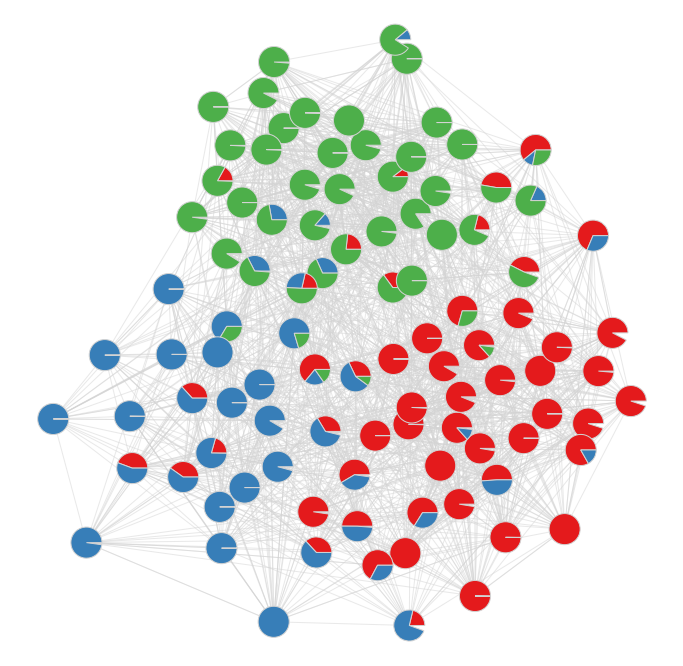

In [16]:
radius = 0.005
plt.figure(figsize=(12,12))
ax = plt.gca()
nx.draw_networkx_edges(G, pos,arrows=False,edge_color='lightgrey',alpha =0.5)
for n in list(G.nodes()):
    degree_n = len(set(G.predecessors(n)).union(set(G.successors(n))))
    degree_n = 10
    wedge_sizes,wedge_colors = extract_overlapping_membership(n,cm,u_norm,threshold=0.1)
    if len(wedge_sizes)>0:
        pie,t = plt.pie(wedge_sizes, center=pos[n], colors = wedge_colors,radius=(min(10,degree_n))*radius,wedgeprops=wedgeprops,normalize=False)
#                 [p.set_zorder(-1) for p in pie]
ax.axis("equal")
# plt.savefig('../figures/SBM_overlapping.png',dpi=100,bbox_inches = 'tight',
#     pad_inches = 0)
plt.show()


### Plot adjacency matrix

In [17]:
umax = np.argmax(u_norm,axis=1)
nodelist = list(np.where(umax == 0)[0])
for k in range(1,K):
    nodelist.extend(list(np.where(umax == k)[0]))

In [18]:
maxA = np.max(A)
cmap1 = ListedColormap(['white', 'paleturquoise','turquoise',  'mediumturquoise','darkturquoise', 'royalblue'][:maxA+1])

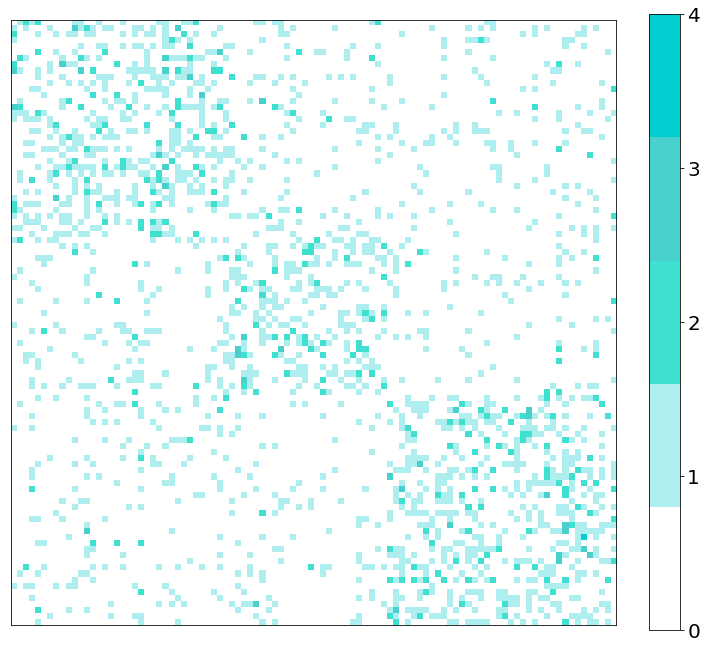

In [19]:
plt.figure(figsize=(12,12))
plt.imshow(A[nodelist][:,nodelist],cmap=cmap1)
cb = plt.colorbar(fraction=0.046, ticks=list(np.arange(np.max(A)+1)))
cb.ax.tick_params(labelsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = plt.gca()
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
# plt.savefig('../figures/SBM_overlappingA.png',dpi=100,bbox_inches = 'tight',
#     pad_inches = 0)

plt.show()